# TMDB Box Office Prediction
>
> https://www.kaggle.com/c/tmdb-box-office-prediction

---



In [24]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ast

## Load Data

In [25]:
# Directory containing the csv files
dir_path = 'data'

train = pd.read_csv(f"{dir_path}/train.csv")
test = pd.read_csv(f"{dir_path}/test.csv")

train.describe(include='all')

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
count,3000.000000,604,3.000000e+03,2993,946,3000,3000,3000,2992,3000.000000,...,3000,2998.000000,2980,3000,2403,3000,2724,2987,2984,3.000000e+03
unique,NaN,422,NaN,872,941,3000,36,2975,2992,NaN,...,2398,NaN,401,2,2400,2969,2648,2975,2984,NaN
top,NaN,"[{'id': 645, 'name': 'James Bond Collection', ...",NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt1600195,en,Lolita,Anna (Marceau) is a wife and mother who has an...,NaN,...,9/10/10,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Deadfall,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '5391990d0e0a260fb5001629', 'de...",NaN
freq,NaN,16,NaN,266,4,1,2575,2,1,NaN,...,5,NaN,1817,2996,3,2,27,13,1,NaN
mean,1500.500000,NaN,2.253133e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.463274,...,NaN,107.856571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.672585e+07
std,866.169729,NaN,3.702609e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.104000,...,NaN,22.086434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375323e+08
min,1.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,...,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,750.750000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.018053,...,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.379808e+06
50%,1500.500000,NaN,8.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.374861,...,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.680707e+07
75%,2250.250000,NaN,2.900000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.890983,...,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.891920e+07


## Exploratory Data Analysis

In [26]:
# Check for missing values
train.isna().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

### Numerical Features

Plotting some of the simple features helps us find a common ground.

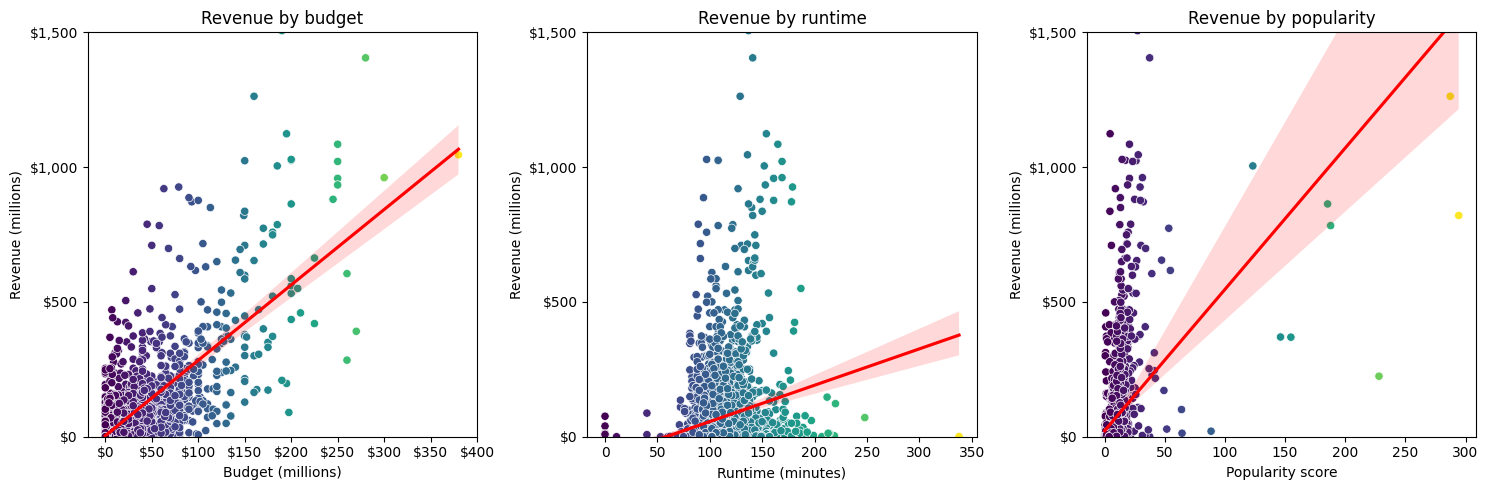

In [27]:
# Budget
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=train.iloc[:3000], x='budget', y='revenue', hue='budget', palette='viridis')
sns.regplot(data=train.iloc[:3000], x='budget', y='revenue', scatter=False, color='red')
plt.xticks([0, 50000000, 100000000, 150000000, 200000000, 250000000, 300000000, 350000000, 400000000], ['$0', '$50', '$100', '$150', '$200', '$250', '$300', '$350', '$400'])
plt.ylim(0, 1500000000)
plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0', '$500', '$1,000', '$1,500'])
plt.title('Revenue by budget')
plt.xlabel('Budget (millions)')
plt.ylabel('Revenue (millions)')
plt.legend().remove()

# Runtime
plt.subplot(1, 3, 2)
sns.scatterplot(data=train.iloc[:3000], x='runtime', y='revenue', hue='runtime', palette='viridis')
sns.regplot(data=train.iloc[:3000], x='runtime', y='revenue', scatter=False, color='red')
plt.ylim(0, 1500000000)
plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0', '$500', '$1,000', '$1,500'])
plt.title('Revenue by runtime')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Revenue (millions)')
plt.legend().remove()

# Popularity
plt.subplot(1, 3, 3)
sns.scatterplot(data=train.iloc[:3000], x='popularity', y='revenue', hue='popularity', palette='viridis')
sns.regplot(data=train.iloc[:3000], x='popularity', y='revenue', scatter=False, color='red')
plt.ylim(0, 1500000000)
plt.yticks([0, 500000000, 1000000000, 1500000000], ['$0', '$500', '$1,000', '$1,500'])
plt.title('Revenue by popularity')
plt.xlabel('Popularity score')
plt.ylabel('Revenue (millions)')
plt.legend().remove()

plt.tight_layout()
plt.show()

Let's take a look at the distribution of the revenue.

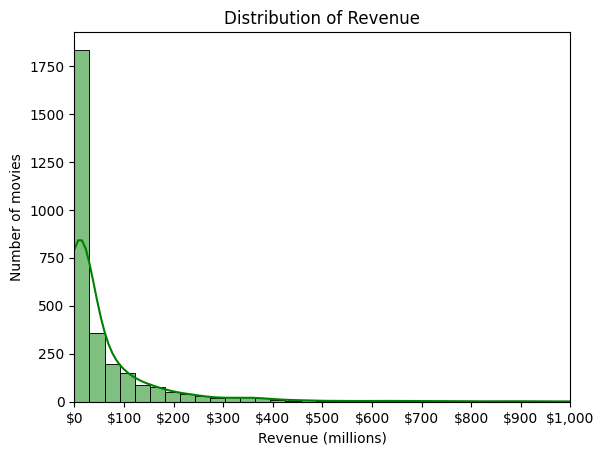

In [28]:
sns.histplot(train.revenue, bins=50, kde=True, color='green')
plt.xlabel('Revenue (millions)')
plt.xticks([0, 100000000, 200000000, 300000000, 400000000, 500000000, 600000000, 700000000, 800000000, 900000000, 1000000000], ['$0', '$100', '$200', '$300', '$400', '$500', '$600', '$700', '$800', '$900', '$1,000'])
plt.xlim(0, 1000000000)
plt.ylabel('Number of movies')
plt.title('Distribution of Revenue')
plt.show()

In [29]:
train.revenue.describe().apply(lambda x: f'{x:,.0f}')

count            3,000
mean        66,725,852
std        137,532,326
min                  1
25%          2,379,808
50%         16,807,068
75%         68,919,204
max      1,519,557,910
Name: revenue, dtype: object

The distribution of the revenue is heavily skewed to the right. Normalization of the datapoints with log can help increase the performance of the model.

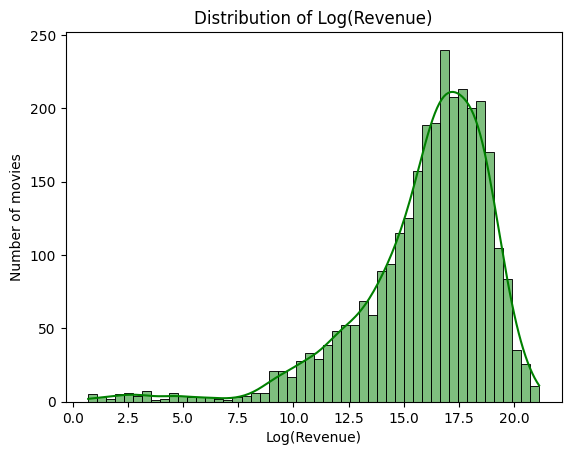

In [30]:
train['log_revenue'] = np.log1p(train.revenue)
sns.histplot(train.log_revenue, bins=50, kde=True, color='green')
plt.xlabel('Log(Revenue)')
plt.ylabel('Number of movies')
plt.title('Distribution of Log(Revenue)')
plt.show()

Taking the logarithm of the revenue lead to a more normal distribution, stabilized variance, and provide coefficients that are easier to interpret in multiplicative terms. These advantages can improve the accuracy and interpretability of the revenue forecasting model.

### List Features

#### Collection

In [31]:
# Extract collection names
train['collection_name'] = train['belongs_to_collection'].apply(lambda x: ast.literal_eval(x)[0]['name'] if pd.notna(x) and ast.literal_eval(x) else None)

# Group by collection name, count occurrences, and sort
collection_counts = train['collection_name'].value_counts().reset_index()
collection_counts.columns = ['collection_name', 'movie_count']

# Filter out collections with no name and display the head
collection_counts = collection_counts[collection_counts['collection_name'].notna()]
collection_counts.head(10)

,collection_name,movie_count
0,James Bond Collection,16
1,Friday the 13th Collection,7
2,The Pink Panther (Original) Collection,6
3,Police Academy Collection,5
4,Pokémon Collection,5
5,Resident Evil Collection,4
6,Rambo Collection,4
7,Ice Age Collection,4
8,Alien Collection,4
9,Paranormal Activity Collection,4


Now for the test data.

In [32]:
# Extract collection names for test dataframe
test['collection_name'] = test['belongs_to_collection'].apply(lambda x: ast.literal_eval(x)[0]['name'] if pd.notna(x) and ast.literal_eval(x) else None)

# Group by collection name, count occurrences, and sort for test dataframe
test_collection_counts = test['collection_name'].value_counts().reset_index()
test_collection_counts.columns = ['collection_name', 'movie_count']

# Filter out collections with no name and display the head for test dataframe
test_collection_counts = test_collection_counts[test_collection_counts['collection_name'].notna()]
test_collection_counts.head(10)

,collection_name,movie_count
0,James Bond Collection,10
1,A Nightmare on Elm Street Collection,8
2,Harry Potter Collection,6
3,Star Wars Collection,6
4,Halloween Collection,5
5,Friday the 13th Collection,5
6,Underworld Collection,5
7,Die Hard Collection,5
8,Saw Collection,5
9,Living Dead Collection,5


Now we change the `belongs_to_collection` feature into something easier to handle like a simple bool.

In [33]:
train['belongs_to_collection'] = train['belongs_to_collection'].apply(lambda x: 1 if pd.notna(x) else 0)
train[['collection_name', 'belongs_to_collection']].head()

,collection_name,belongs_to_collection
0,Hot Tub Time Machine Collection,1
1,The Princess Diaries Collection,1
2,None,0
3,None,0
4,None,0


In [34]:
test['belongs_to_collection'] = test['belongs_to_collection'].apply(lambda x: 1 if pd.notna(x) else 0)
test[['collection_name', 'belongs_to_collection']].head()

,collection_name,belongs_to_collection
0,Pokémon Collection,1
1,None,0
2,None,0
3,None,0
4,None,0


Let's plot the results.

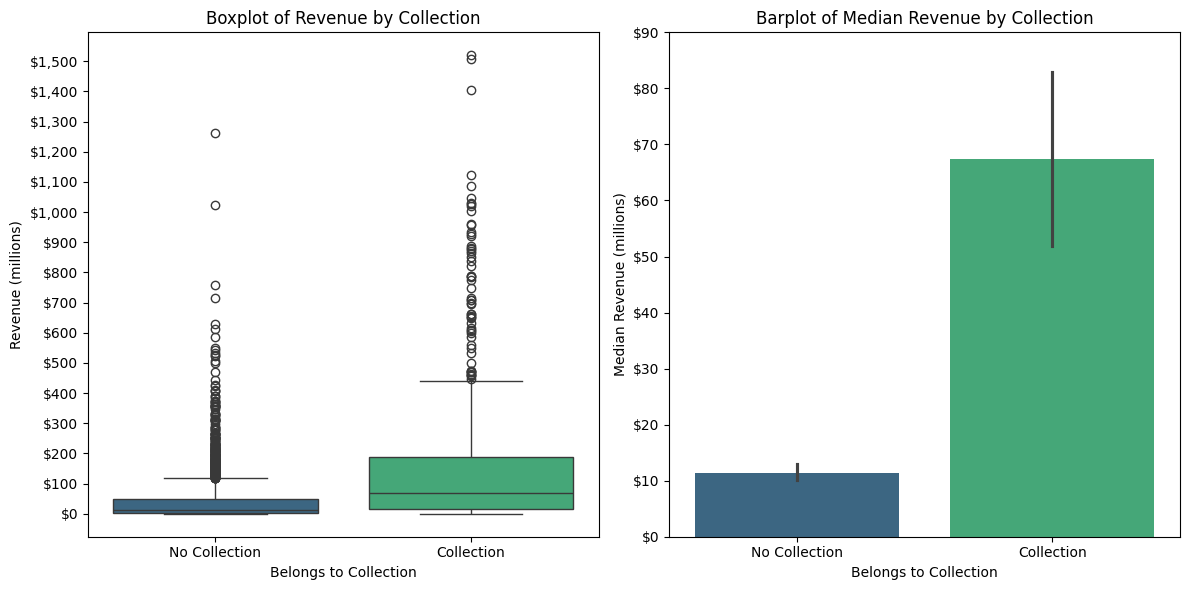

In [35]:
# Create subplots
plt.figure(figsize=(12, 6))

# Boxplot for revenue by belongs_to_collection
plt.subplot(1, 2, 1)
sns.boxplot(data=train, x='belongs_to_collection', y='revenue', hue='belongs_to_collection', palette='viridis')
plt.xticks([0, 1], ['No Collection', 'Collection'])
plt.xlabel('Belongs to Collection')
plt.ylabel('Revenue (millions)')
plt.yticks(np.arange(0, 1600000000, 100000000), [f'${x//1000000:,}' for x in np.arange(0, 1600000000, 100000000)])
plt.title('Boxplot of Revenue by Collection')
plt.legend().remove()

# Barplot for median revenue by belongs_to_collection
plt.subplot(1, 2, 2)
sns.barplot(data=train, x='belongs_to_collection', y='revenue', estimator=np.median, hue='belongs_to_collection', palette='viridis')
plt.xticks([0, 1], ['No Collection', 'Collection'])
plt.xlabel('Belongs to Collection')
plt.ylabel('Median Revenue (millions)')
plt.yticks(np.arange(0, 100000000, 10000000), [f'${x//1000000:,}' for x in np.arange(0, 100000000, 10000000)])
plt.title('Barplot of Median Revenue by Collection')
plt.legend().remove()

plt.tight_layout()
plt.show()

So we can see here that movies which belong to a collection seem to get higher revenues.

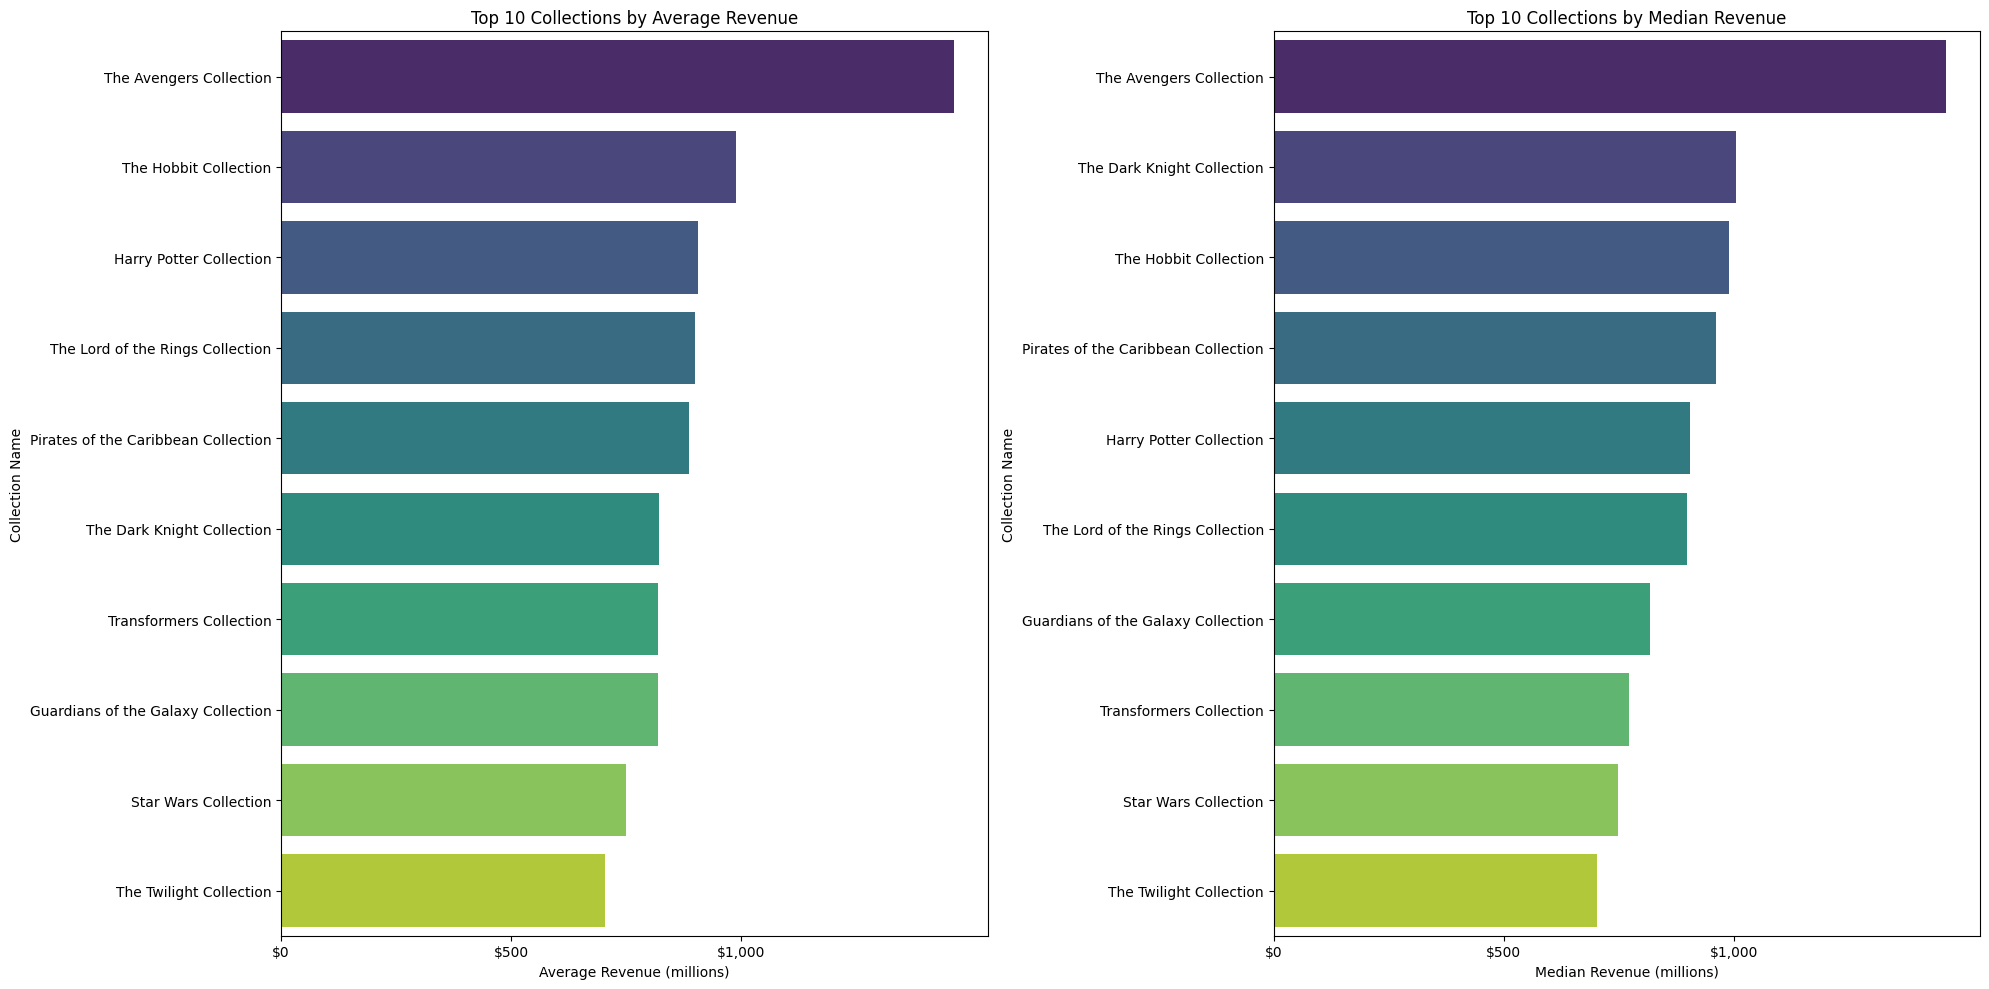

In [36]:
# Define valid collections
valid_collections = collection_counts[collection_counts['movie_count'] > 1]['collection_name']

# Group by collection_name and calculate the median revenue for valid collections
collection_median_revenue = train[train['collection_name'].isin(valid_collections)].groupby('collection_name')['revenue'].median().reset_index()

# Sort the collections by median revenue in descending order and select the top 10
collection_median_revenue = collection_median_revenue.sort_values(by='revenue', ascending=False).head(10)

# Calculate the average revenue for valid collections
collection_revenue = train[train['collection_name'].isin(valid_collections)].groupby('collection_name')['revenue'].mean().reset_index()

# Sort the collections by average revenue in descending order and select the top 10
collection_revenue = collection_revenue.sort_values(by='revenue', ascending=False).head(10)

# Plot the data
plt.figure(figsize=(20, 10))

# Average revenue plot
plt.subplot(1, 2, 1)
sns.barplot(data=collection_revenue, x='revenue', y='collection_name', hue='collection_name', palette='viridis')
plt.xlabel('Average Revenue (millions)')
plt.ylabel('Collection Name')
plt.title('Top 10 Collections by Average Revenue')
plt.xticks(np.arange(0, collection_revenue['revenue'].max(), step=500000000), [f'${int(x//1000000):,}' for x in np.arange(0, collection_revenue['revenue'].max(), step=500000000)])

# Median revenue plot
plt.subplot(1, 2, 2)
sns.barplot(data=collection_median_revenue, x='revenue', y='collection_name', hue='collection_name', palette='viridis')
plt.xlabel('Median Revenue (millions)')
plt.ylabel('Collection Name')
plt.title('Top 10 Collections by Median Revenue')
plt.xticks(np.arange(0, collection_median_revenue['revenue'].max(), step=500000000), [f'${int(x//1000000):,}' for x in np.arange(0, collection_median_revenue['revenue'].max(), step=500000000)])

plt.tight_layout()
plt.show()

Here we can see the collections with the highest revenues by average and median.

#### Genre

Looking at the dataset 

In [37]:
# Count the number of genres per movie
train['genre_count'] = train['genres'].apply(lambda x: len(ast.literal_eval(x)) if pd.notna(x) else 0)

# Count the number of movies for each genre count
genre_count_distribution = train['genre_count'].value_counts().sort_index()

# Display the distribution
genre_count_distribution

genre_count
0      7
1    593
2    972
3    900
4    393
5    111
6     21
7      3
Name: count, dtype: int64

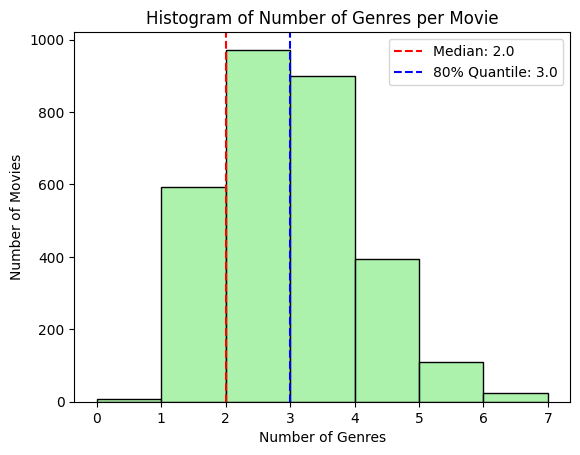

In [38]:
# Calculate the median and 0.8 quantile of genre_count
median_genre_count = train['genre_count'].median()
quantile_80_genre_count = train['genre_count'].quantile(0.80)

# Plot the histogram
sns.histplot(train['genre_count'], bins=range(0, train['genre_count'].max() + 1), kde=False, color='lightgreen')

# Add a vertical line for the median
plt.axvline(median_genre_count, color='red', linestyle='--', label=f'Median: {median_genre_count}')

# Add a vertical line for the 0.8 quantile
plt.axvline(quantile_80_genre_count, color='blue', linestyle='--', label=f'80% Quantile: {quantile_80_genre_count}')

# Add labels and title
plt.xlabel('Number of Genres')
plt.ylabel('Number of Movies')
plt.title('Histogram of Number of Genres per Movie')
plt.legend()

# Show the plot
plt.show()

80% of the samples have either 1, 2 or 3 genres. This might lead to the conclusion that the most significant genres in a list are the first 3. Let's find out which one is the most significant one.

In [39]:
# Function to extract genres
def extract_genres(genres, index):
    try:
        return ast.literal_eval(genres)[index]['name']
    except (IndexError, ValueError, TypeError):
        return None

# Create new columns for the first three genres
train['genre_1'] = train['genres'].apply(lambda x: extract_genres(x, 0))
train['genre_2'] = train['genres'].apply(lambda x: extract_genres(x, 1))
train['genre_3'] = train['genres'].apply(lambda x: extract_genres(x, 2))

# Display the first few rows to verify
train[['genres', 'genre_1', 'genre_2', 'genre_3']].head()

,genres,genre_1,genre_2,genre_3
0,"[{'id': 35, 'name': 'Comedy'}]",Comedy,None,None
1,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",Comedy,Drama,Family
2,"[{'id': 18, 'name': 'Drama'}]",Drama,None,None
3,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",Thriller,Drama,None
4,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",Action,Thriller,None


In [40]:
# Concatenate the genre columns
all_genres = pd.concat([train['genre_1'], train['genre_2'], train['genre_3']])

# Count the occurrences of each genre
genre_appearances = all_genres.value_counts()

# Display the most occurring genres
print(genre_appearances.head(20))

Drama              1496
Comedy             1005
Action              731
Thriller            609
Romance             493
Crime               422
Adventure           414
Horror              290
Science Fiction     217
Family              208
Fantasy             201
Mystery             178
Animation           138
History             112
Music                88
Documentary          87
War                  75
Western              31
Foreign              25
TV Movie              1
Name: count, dtype: int64


The genres that appear the most are Drama, Comedy, Action and Thriller. Let's see if they are also the ones with the highest revenue.

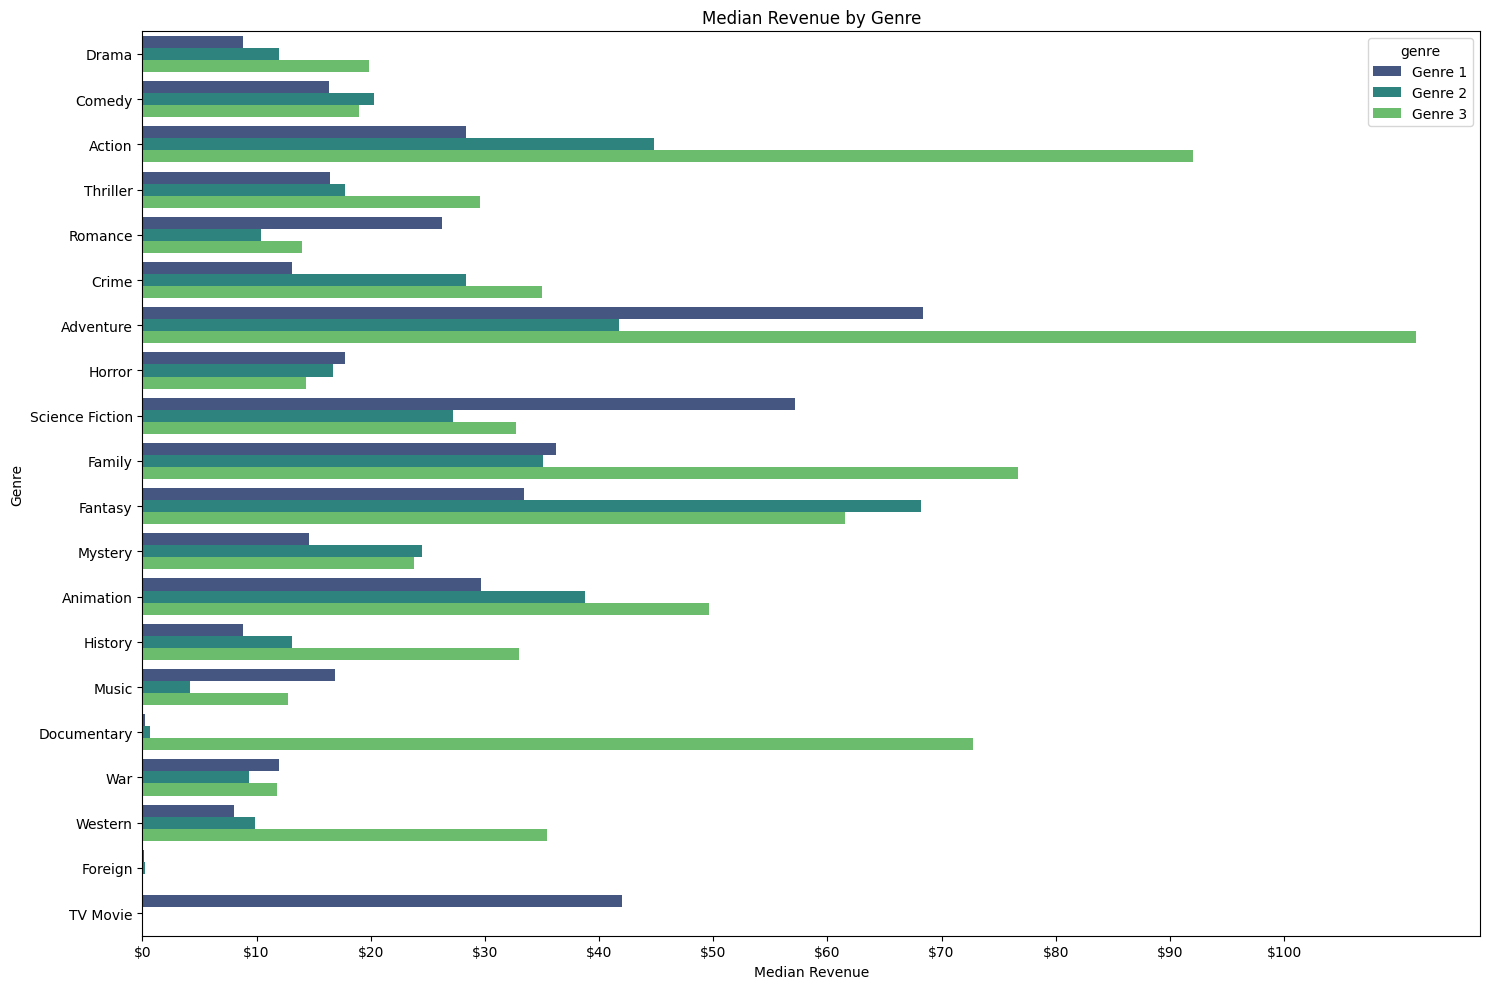

In [50]:
# Calculate the median revenue for each genre
genre_1_median_revenue = train.groupby('genre_1')['revenue'].median().reset_index()
genre_2_median_revenue = train.groupby('genre_2')['revenue'].median().reset_index()
genre_3_median_revenue = train.groupby('genre_3')['revenue'].median().reset_index()

# Combine the three genre median revenue DataFrames
genre_1_median_revenue['genre'] = 'Genre 1'
genre_2_median_revenue['genre'] = 'Genre 2'
genre_3_median_revenue['genre'] = 'Genre 3'

combined_genre_revenue = pd.concat([
    genre_1_median_revenue.rename(columns={'genre_1': 'genre_name'}),
    genre_2_median_revenue.rename(columns={'genre_2': 'genre_name'}),
    genre_3_median_revenue.rename(columns={'genre_3': 'genre_name'})
])

# Ensure the genres are ordered according to genre_appearances
combined_genre_revenue['genre_name'] = pd.Categorical(
    combined_genre_revenue['genre_name'],
    categories=genre_appearances.index,
    ordered=True
)

# Plot the combined data
plt.figure(figsize=(15, 10))
sns.barplot(data=combined_genre_revenue, x='revenue', y='genre_name', hue='genre', palette='viridis')
plt.xlabel('Median Revenue')
plt.ylabel('Genre')
plt.title('Median Revenue by Genre')
plt.xticks(np.arange(0, 110000000, 10000000), [f'${x//1000000:,}' for x in np.arange(0, 110000000, 10000000)])
plt.tight_layout()
plt.show()


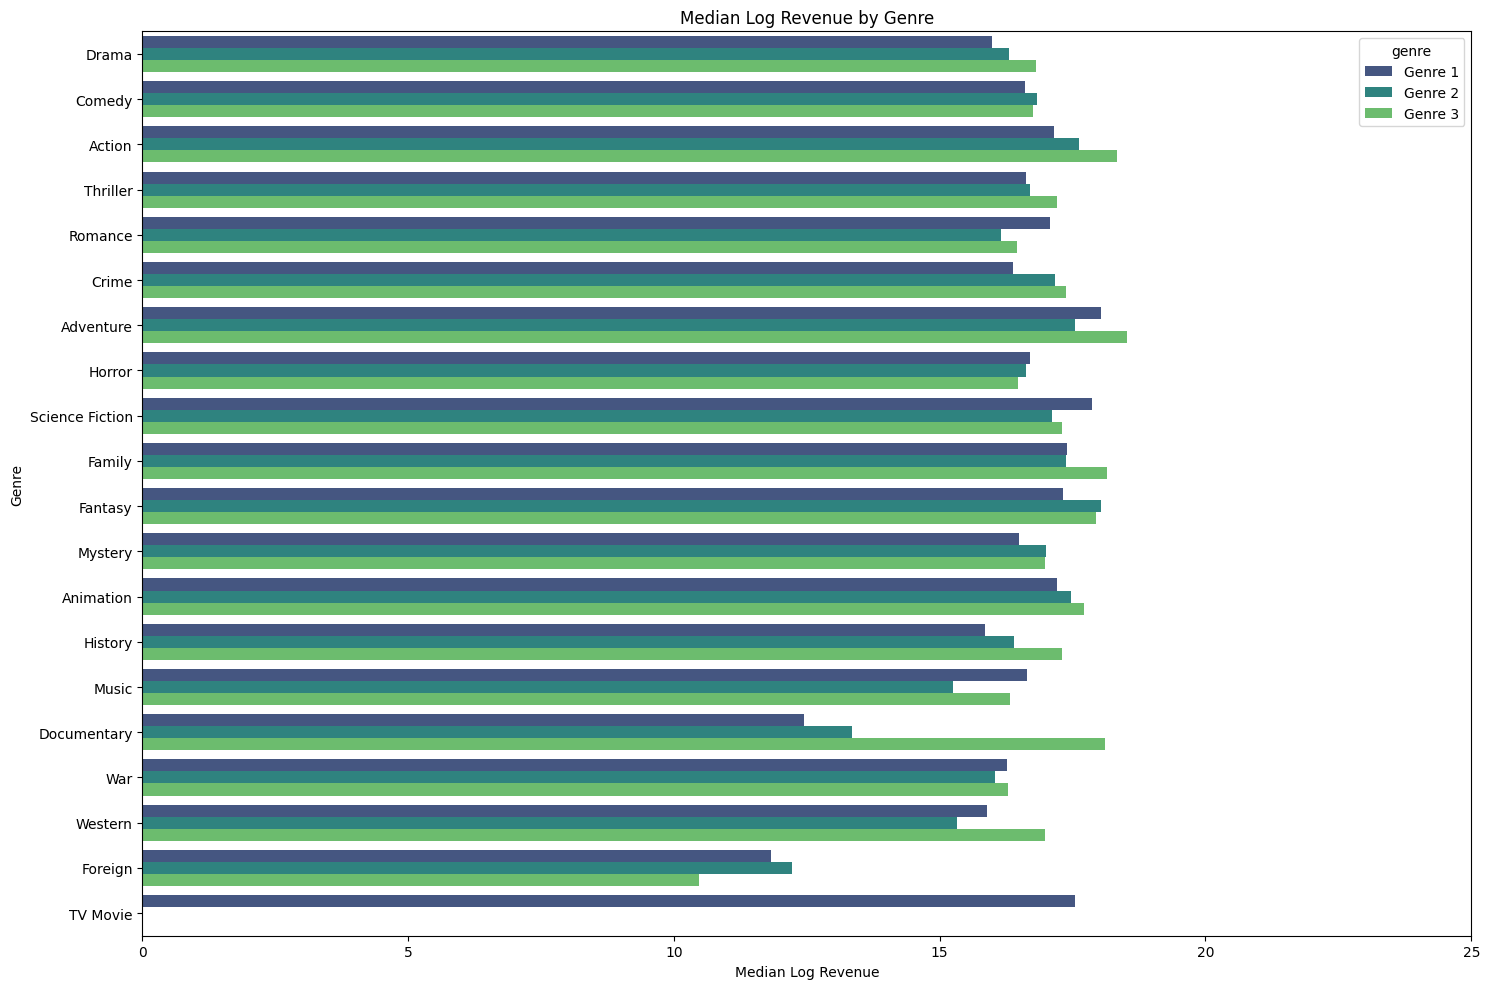

In [49]:
# Calculate the median log revenue for each genre
genre_1_median_log_revenue = train.groupby('genre_1')['log_revenue'].median().reset_index()
genre_2_median_log_revenue = train.groupby('genre_2')['log_revenue'].median().reset_index()
genre_3_median_log_revenue = train.groupby('genre_3')['log_revenue'].median().reset_index()

# Combine the three genre median log_revenue DataFrames
genre_1_median_log_revenue['genre'] = 'Genre 1'
genre_2_median_log_revenue['genre'] = 'Genre 2'
genre_3_median_log_revenue['genre'] = 'Genre 3'

combined_genre_log_revenue = pd.concat([
    genre_1_median_log_revenue.rename(columns={'genre_1': 'genre_name'}),
    genre_2_median_log_revenue.rename(columns={'genre_2': 'genre_name'}),
    genre_3_median_log_revenue.rename(columns={'genre_3': 'genre_name'})
])

# Ensure the genres are ordered according to genre_appearances
combined_genre_log_revenue['genre_name'] = pd.Categorical(
    combined_genre_log_revenue['genre_name'],
    categories=genre_appearances.index,
    ordered=True
)

# Plot the combined data
plt.figure(figsize=(15, 10))
sns.barplot(data=combined_genre_log_revenue, x='log_revenue', y='genre_name', hue='genre', palette='viridis')
plt.xlabel('Median Log Revenue')
plt.ylabel('Genre')
plt.title('Median Log Revenue by Genre')
plt.xticks(np.arange(0, 26, 5), [f'{x}' for x in np.arange(0, 26, 5)])
plt.tight_layout()
plt.show()


TODO find out which one is the most significant of the three genre columns